<a href="https://colab.research.google.com/github/JuniorTorresMTJ/TowerBank/blob/main/notebooks/TowerBank_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***
***
#TowerBank - Criação do Modelo Preditivo
***
***

<img src="https://raw.githubusercontent.com/JuniorTorresMTJ/TowerBank/main/img/TowerBankLog.png" alt="win" width="800"/>

***
#OBJETIVO
***

***
#IMPORTAÇÃO DAS BIBLIOTECAS
***

In [67]:
import pandas            as pd
import numpy             as np
from google.colab import files
from scipy import stats
from sklearn.pipeline import Pipeline

#bibliotecas de visualização

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn           as sns

#Bibliotecas de Pré-processamento

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

#Bibliotecas de Modelo de Machine Learning

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#Bibliotecas de Avaliação do Modelo
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

***
#DADOS
***

In [68]:
df_credito = pd.read_csv('https://raw.githubusercontent.com/JuniorTorresMTJ/TowerBank/main/dados/dados_clientes_targets.csv')


***
#PRÉ-PROCESSAMENTO
***

In [69]:
df_credito.head()

,ID_Cliente,Tem_Carro,Tem_Casa_Propria,Qtd_Filhos,Rendimento_Anual,Categoria_de_renda,Grau_Escolaridade,Estado_Civil,Moradia,Idade,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Ocupacao,Tamanho_Familia,Anos_empregado,Mau
0,5008806,1,1,0,112500.0,Empregado,Ensino medio,Casado,Casa propria,59.0,0,0,0,Seguranca,2.0,3.1,0
1,5008810,0,1,0,270000.0,Associado comercial,Ensino medio,Solteiro,Casa propria,52.0,0,1,1,Venda,1.0,8.4,0
2,5008811,0,1,0,270000.0,Associado comercial,Ensino medio,Solteiro,Casa propria,52.0,0,1,1,Venda,1.0,8.4,0
3,5008812,0,1,0,283500.0,Pensionista,Ensino superior,Separado,Casa propria,62.0,0,0,0,Outros,1.0,-1.0,0
4,5008813,0,1,0,283500.0,Pensionista,Ensino superior,Separado,Casa propria,62.0,0,0,0,Outros,1.0,-1.0,0


In [70]:
colunas_categoricas_binarias = ['Tem_Carro',
                                'Tem_Casa_Propria',
                                'Tem_telefone_trabalho',
                                'Tem_telefone_fixo',
                                'Tem_email']
colunas_categoricas_binarias

['Tem_Carro',
 'Tem_Casa_Propria',
 'Tem_telefone_trabalho',
 'Tem_telefone_fixo',
 'Tem_email']

In [71]:
colunas_categoricas_nao_binarias = ['Categoria_de_renda',
                                    'Grau_Escolaridade',
                                    'Estado_Civil',
                                    'Moradia',
                                    'Ocupacao']
colunas_categoricas_nao_binarias

['Categoria_de_renda',
 'Grau_Escolaridade',
 'Estado_Civil',
 'Moradia',
 'Ocupacao']

In [72]:
colunas_continuas = ['Idade', 'Qtd_Filhos', 'Rendimento_Anual', 'Anos_empregado', 'Tamanho_Familia']

In [73]:
colunas_categoricas = ['Tem_Carro', 'Tem_Casa_Propria',
                       'Categoria_de_renda', 'Grau_Escolaridade',
                       'Estado_Civil', 'Moradia','Tem_telefone_trabalho', 'Tem_telefone_fixo', 'Tem_email',
                       'Ocupacao']

In [74]:
df_registro_clientes_targets = df_credito[['ID_Cliente'] + colunas_continuas + colunas_categoricas_binarias + colunas_categoricas_nao_binarias + ['Mau']]
df_registro_clientes_targets.head()

,ID_Cliente,Idade,Qtd_Filhos,Rendimento_Anual,Anos_empregado,Tamanho_Familia,Tem_Carro,Tem_Casa_Propria,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Categoria_de_renda,Grau_Escolaridade,Estado_Civil,Moradia,Ocupacao,Mau
0,5008806,59.0,0,112500.0,3.1,2.0,1,1,0,0,0,Empregado,Ensino medio,Casado,Casa propria,Seguranca,0
1,5008810,52.0,0,270000.0,8.4,1.0,0,1,0,1,1,Associado comercial,Ensino medio,Solteiro,Casa propria,Venda,0
2,5008811,52.0,0,270000.0,8.4,1.0,0,1,0,1,1,Associado comercial,Ensino medio,Solteiro,Casa propria,Venda,0
3,5008812,62.0,0,283500.0,-1.0,1.0,0,1,0,0,0,Pensionista,Ensino superior,Separado,Casa propria,Outros,0
4,5008813,62.0,0,283500.0,-1.0,1.0,0,1,0,0,0,Pensionista,Ensino superior,Separado,Casa propria,Outros,0


In [75]:
!pip install scikit-learn==0.23.2 imbalanced-learn==0.7.0

In [76]:
SEED = 1561651

In [77]:
SEED = 1561651
def roda_modelo(modelo, dados):

    # separando dados em x e y, e tambem removendo a coluna de ID_cliente
    x = dados.drop(['ID_Cliente', 'Mau'], axis=1)
    y = dados.drop('ID_Cliente', axis=1)['Mau']
    
    # Separando dados em treino e teste
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=SEED)

    # Treinando modelo com os dados de treino
    modelo.fit(x_train, y_train)

    # Calculando a probabilidade e calculando o AUC
    prob_predic = modelo.predict_proba(x_test)
    auc = roc_auc_score(y_test, prob_predic[:,1])
    print(f"AUC {auc}")
    
    # Separando a probabilidade de ser bom e mau, e calculando o KS
    data_bom = np.sort(modelo.predict_proba(x_test)[:, 1])
    data_mau = np.sort(modelo.predict_proba(x_test)[:, 0])
    kstest = stats.ks_2samp(data_bom, data_mau)
    print(f"KS {kstest}")

    # Criando matriz de confusão
    matriz_confusao = plot_confusion_matrix(modelo, x_test, y_test, values_format='.0f', display_labels=['Bons', 'Maus'])
    plt.grid(False)    
    plt.show(matriz_confusao)

    # Fazendo a predicao dos dados de teste e calculando o classification report
    predicao = modelo.predict(x_test)
    print("\nClassification Report")
    print(classification_report(y_test, predicao, zero_division=0))

In [78]:
# PEP8 padrão CamelCase
class Transformador(BaseEstimator, TransformerMixin):
    def __init__( self, colunas_continuas, colunas_categoricas):
        self.colunas_continuas = colunas_continuas
        self.colunas_categoricas = colunas_categoricas
        self.enc = OneHotEncoder()
        self.scaler = MinMaxScaler()

    def fit(self, X, y = None ):
        self.enc.fit(X[self.colunas_categoricas])
        self.scaler.fit(X[self.colunas_continuas])
        return self 

    def transform(self, X, y = None):
      
      X_categoricas = pd.DataFrame(data=self.enc.transform(X[self.colunas_categoricas]).toarray(),
                                  columns= self.enc.get_feature_names(self.colunas_categoricas))
      
      X_continuas = pd.DataFrame(data=self.scaler.transform(X[self.colunas_continuas]),
                                  columns= self.colunas_continuas)
      
      X = pd.concat([X_continuas, X_categoricas], axis=1)

      return X

AUC 0.5
KS Ks_2sampResult(statistic=1.0, pvalue=0.0)


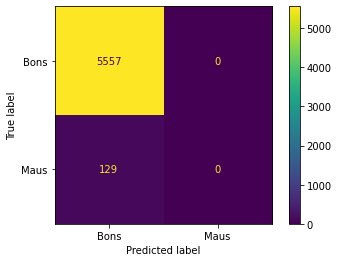


Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5557
           1       0.00      0.00      0.00       129

    accuracy                           0.98      5686
   macro avg       0.49      0.50      0.49      5686
weighted avg       0.96      0.98      0.97      5686



In [79]:
pipeline = Pipeline([('Transformador', Transformador(colunas_continuas, colunas_categoricas)),
                     ('Modelo', DummyClassifier(strategy='prior'))])   
roda_modelo(pipeline, df_registro_clientes_targets)